In [1]:
# Restart the session after running this cell (Run it once!)
!git clone https://github.com/sparisi/gym_gridworlds
!pip install -e ./gym_gridworlds

Cloning into 'gym_gridworlds'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 166 (delta 22), reused 17 (delta 17), pack-reused 139 (from 1)
Receiving objects: 100% (166/166), 68.22 KiB | 554.00 KiB/s, done.
Resolving deltas: 100% (86/86), done.
Obtaining file:///content/gym_gridworlds
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 18.2 MB/s eta 0:00:00
  Running setup.py develop for Gym-Gridworlds


# Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Register Envoronments in Gym

In [1]:
from gymnasium.envs.registration import register

register(
    id="Gym-Gridworlds/Straight-20-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=200,
    kwargs={
        "grid": "20_straight",
    },
)

register(
    id="Gym-Gridworlds/Empty-2x2-v0",
    entry_point="gym_gridworlds.gridworld:GridworldRandomStart",
    max_episode_steps=10,
    kwargs={
        "grid": "2x2_empty",
    },
)

register(
    id="Gym-Gridworlds/Empty-3x3-v0",
    entry_point="gym_gridworlds.gridworld:GridworldRandomStart",
    max_episode_steps=50,
    kwargs={
        "grid": "3x3_empty",
    },
)

register(
    id="Gym-Gridworlds/Empty-Loop-3x3-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "3x3_empty_loop",
    },
)

register(
    id="Gym-Gridworlds/Empty-10x10-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=100,
    kwargs={
        "grid": "10x10_empty",
    },
)

register(
    id="Gym-Gridworlds/Empty-Distract-6x6-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "6x6_distract",
    },
)

register(
    id="Gym-Gridworlds/Penalty-3x3-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "3x3_penalty",
    },
)

register(
    id="Gym-Gridworlds/Quicksand-4x4-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "4x4_quicksand",
    },
)

register(
    id="Gym-Gridworlds/Quicksand-Distract-4x4-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "4x4_quicksand_distract",
    },
)

register(
    id="Gym-Gridworlds/TwoRoom-Quicksand-3x5-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "3x5_two_room_quicksand",
    },
)

register(
    id="Gym-Gridworlds/Corridor-3x4-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "3x4_corridor",
    },
)
register(
    id="Gym-Gridworlds/Full-4x5-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "4x5_full",
    },
)

register(
    id="Gym-Gridworlds/TwoRoom-Distract-Middle-2x11-v0",
    entry_point="gym_gridworlds.gridworld:GridworldMiddleStart",
    max_episode_steps=200,
    kwargs={
        "grid": "2x11_two_room_distract",
    },
)

register(
    id="Gym-Gridworlds/Barrier-5x5-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "5x5_barrier",
    },
)

register(
    id="Gym-Gridworlds/RiverSwim-6-v0",
    entry_point="gym_gridworlds.gridworld:RiverSwim",
    max_episode_steps=200,
    kwargs={
        "grid": "river_swim_6",
    },
)

register(
    id="Gym-Gridworlds/CliffWalk-4x12-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=200,
    kwargs={
        "grid": "4x12_cliffwalk",
    },
)

register(
    id="Gym-Gridworlds/DangerMaze-6x6-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=200,
    kwargs={
        "grid": "6x6_danger_maze",
    },
)

# Import Libraries

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import gym
import gymnasium
from tqdm import trange
import matplotlib.pyplot as plt
import json

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Feature Functions

In [5]:
def rbf_features(
    state,
    centers,
    sigmas: float,
):
    state = torch.tensor(state, device=device)
    centers = torch.tensor(centers, device=device)
    D = centers.shape[0]
    N = state.shape[0]
    new_state = state[:, None, :].repeat(1, D, 1)
    new_center = centers.repeat(N, 1, 1)
    return torch.exp(-torch.linalg.norm(new_state - new_center, 2, axis=2)**2 / sigmas**2 / 2)


def tile_features(
    state: np.array,  # (N, S)
    centers: np.array,  # (D, S)
    widths: float,
    offsets: list = [0],  # list of tuples of length S
) -> np.array:  # (N, D)

    D = np.shape(centers)[0]
    N = np.shape(state)[0]
    new_state = np.repeat(state[:, None, :], D, axis=1)
    output = np.zeros((N, D))
    for offset in offsets:
        shifted_center = centers + offset
        new_center = np.repeat(shifted_center[None, :, :], N, axis=0)
        output += np.array(np.linalg.norm(new_state - new_center, np.inf, axis=2) < widths, dtype=np.float32)

    return output / len(offsets)


def coarse_features(
    state: np.array,  # (N, S)
    centers: np.array,  # (D, S)
    widths: float,
    offsets: list = [0],  # list of tuples of length S
) -> np.array:  # (N, D)

    D = np.shape(centers)[0]
    N = np.shape(state)[0]
    new_state = np.repeat(state[:, None, :], D, axis=1)
    output = np.zeros((N, D))
    for offset in offsets:
        shifted_center = centers + offset
        new_center = np.repeat(shifted_center[None, :, :], N, axis=0)
        output += np.array(np.linalg.norm(new_state - new_center, 2, axis=2) < widths, dtype=np.float32)

    return output / len(offsets)

def aggregation_features(state, centers):
    state = torch.tensor(state, device=device)
    centers = torch.tensor(centers, device=device)

    distance = torch.sum((state[:, None, :] - centers[None, :, :])**2, dim=-1)
    return (distance == distance.min(-1, keepdims=True).values) * 1.0  # make it float


In [6]:
s = np.array([[1, 2]])
c = np.array([[0, 0], [1, 1], [4, 4], [6, 6]])
aggregation_features(s, c)

tensor([[0., 1., 0., 0.]], device='cuda:0')

# Network

In [7]:
# Define the neural network model
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, depth, fc_unit, final_layer_unit):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.feature_size = self.feature_extract_init(state_size, action_size)

        self.layers = nn.ModuleList()
        for i in range(depth):
            if depth == 1:
                self.layers.append(nn.Linear(self.feature_size, final_layer_unit))
            elif i == 0:
                self.layers.append(nn.Linear(self.feature_size, fc_unit))
            elif i == depth - 1:
                self.layers.append(nn.Linear(fc_unit, final_layer_unit))
            else:
                self.layers.append(nn.Linear(fc_unit, fc_unit))

        for layer in self.layers:
          self.init_weights(layer)

        if depth > 0:
          self.final_layer = nn.Linear(final_layer_unit, action_size)
        else:
          self.final_layer = nn.Linear(self.feature_size, action_size)

        self.init_weights(self.final_layer)

    def init_weights(self, layer):
        nn.init.xavier_normal(layer.weight)
        self.to(device)

    def feature_extract_init(self, state_size, action_size):
        n_centers = [10, 10]
        centers = np.array(
          np.meshgrid(*[
              np.linspace(env.observation_space.low[i], env.observation_space.high[i], n_centers[i])
              for i in range(env.observation_space.shape[0])
          ])
        ).reshape(env.observation_space.shape[0], -1).T
        centers = torch.tensor(centers).float().to(device)
        #self.feature_name, self.feature_extract = "Aggregate", lambda state : aggregation_features(state.reshape(-1, state_size), centers)
        self.feature_name, self.feature_extract = "RBF", lambda state : rbf_features(state.reshape(-1, state_size), centers, 0.2)
        return self.feature_extract(env.reset()[0]).shape[1]


    def forward(self, state):
        x = self.feature_extract(state)
        for layer in self.layers:
            x = layer(x)
        return self.final_layer(x)


# ReplayBuffer

In [8]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# DQN

In [9]:
# Define the DQN agent class
class DQNAgent:
    # Initialize the DQN agent
    def __init__(self, state_size, action_size, seed, lr, network):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed, network["depth"], network["fc_units"], network["final_fc_units"]).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, network["depth"], network["fc_units"], network["final_fc_units"]).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)

        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > 64:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    # Choose an action based on the current state
    def act(self, state, eps=0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)

    # Learn from batch of experiences
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = zip(*experiences)
        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(device)

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)

        return loss

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

# Hyperparameters

In [17]:
num_episodes = 4000
max_steps_per_episode_train = 100
max_steps_per_episode_eval = 25
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_rate = 0.995
gamma = 0.9
lr = 1e-3
buffer_size = 10000
batch_size = 512
update_frequency = 10
test_episodes = 1

# Setup Environment

In [18]:
env_id = "Gym-Gridworlds/DangerMaze-6x6-v0"
#env_id = "Gym-Gridworlds/Empty-10x10-v0"
#env_id = "Gym-Gridworlds/Penalty-3x3-v0"
env = gymnasium.make(env_id, coordinate_observation=True)
env_eval = gymnasium.make(env_id, coordinate_observation=True, max_episode_steps=max_steps_per_episode_eval)

# DQN Agent

In [19]:
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]
fc_units = [4096, 608, 440, 363, 316, 284, 260, 241, 226, 213, 148, 93]
final_units = [4102, 608, 440, 363, 318, 284, 260, 245, 228, 222, 149, 58]
networks = [QNetwork(input_dim, output_dim, seed=i, depth=depths[i], fc_unit=fc_units[i], final_layer_unit=final_units[i]) for i in range(len(depths))]
netwrok_names = [f"DQN_{depths[i]:02}_{fc_units[i]}_{sum(p.numel() for p in networks[i].parameters())}" for i in range(len(depths))]
data = {}
for network in networks:
  data[network] = {"loss": [], "train_reward": [], "eval_reward": []}

netwrok_names

['DQN_01_4096_434817',
 'DQN_02_608_434725',
 'DQN_03_440_434725',
 'DQN_04_363_434879',
 'DQN_05_316_434833',
 'DQN_06_284_434809',
 'DQN_07_260_434725',
 'DQN_08_241_434793',
 'DQN_09_226_434841',
 'DQN_10_213_434792',
 'DQN_20_148_434835',
 'DQN_50_93_434756']

# Evaluation

In [20]:
def eval(new_agent):
  episode_rewards = []

  for episode in range(test_episodes):
      state, _ = env_eval.reset()
      episode_reward = 0
      done = False
      while not done:
          action = new_agent.act(state, eps=0.)
          next_state, reward, terminated, truncated, _ = env_eval.step(action)
          done = terminated or truncated
          episode_reward += reward
          state = next_state

      episode_rewards.append(episode_reward)

  average_reward = sum(episode_rewards) / test_episodes
  return average_reward

# Training

In [ ]:
for seed in range(10):
  print(f"seed = {seed}")
  for i, network in enumerate(networks):

    if i not in [0, 4, 9]:
      continue

    if i == 0 and seed == 0:
      continue

    buffer = deque(maxlen=buffer_size)

    new_agent = DQNAgent(input_dim, output_dim, seed=seed, lr = lr, network={"depth": depths[i], "fc_units": fc_units[i], "final_fc_units": final_units[i]})

    # Training

    losses = []
    rewards = []
    average_rewards = []

    ep_mean_reward = 0
    ep_mean_reward_fixed = 0
    ep_mean_loss = 0
    epsilon = epsilon_start

    pbar = trange(num_episodes, position=0, leave=True, desc=f"{netwrok_names[i]}", unit="episode")

    for episode in pbar:
        # Reset the environment
        state, _ = env.reset()
        epsilon = max(epsilon_end, epsilon * epsilon_decay_rate)

        ep_reward = 0
        ep_loss = 0
        # Run one episode
        for step in range(max_steps_per_episode_train):
            # Choose and perform an action
            action = new_agent.act(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            buffer.append((state, action, reward, next_state, done))

            #print(len(buffer), batch_size)
            if len(buffer) >= batch_size:
                batch = random.sample(buffer, batch_size)
                # Update the agent's knowledge
                loss = new_agent.learn(batch, gamma)
                ep_loss += loss

            state = next_state

            ep_reward += reward
            # Check if the episode has ended
            if done:
                break

        if ep_loss == 0:
          record = 0
          pbar.set_postfix(loss=ep_loss, ep_reward=ep_mean_reward_fixed, train_reward=ep_reward)
          losses.append(ep_loss)
        else:
          record = 1
          pbar.set_postfix(loss=ep_loss.item(), ep_reward=ep_mean_reward_fixed, train_reward=ep_reward)
          losses.append(ep_loss.detach().cpu())

        rewards.append(ep_reward)
        ep_mean_reward += ep_reward
        if episode % update_frequency == 0:
          ep_mean_reward_fixed = ep_mean_reward
          average_reward = eval(new_agent)
          ep_mean_reward = 0

        average_rewards.append(average_reward)

    data[network]["eval_reward"].append(average_rewards)
    if record == 1:
      data[network]["loss"].append(losses)
    data[network]["train_reward"].append(rewards)

    to_be_saved = {"loss": np.array(losses).tolist(), "train_reward": rewards, "eval_reward": average_rewards}
    with open(f"/content/drive/MyDrive/Shared Shortcuts/RL_Project/{netwrok_names[i][4:6]} - Hamid/{netwrok_names[i][:7]}{seed}.json", "w") as f:
      json.dump(to_be_saved, f)

seed = 0


DQN_05_316_434833:   9%|▉         | 375/4000 [00:48<14:18,  4.22episode/s, ep_reward=-1040.0, loss=0.014, train_reward=-100]

# Visualization

tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>)
-100


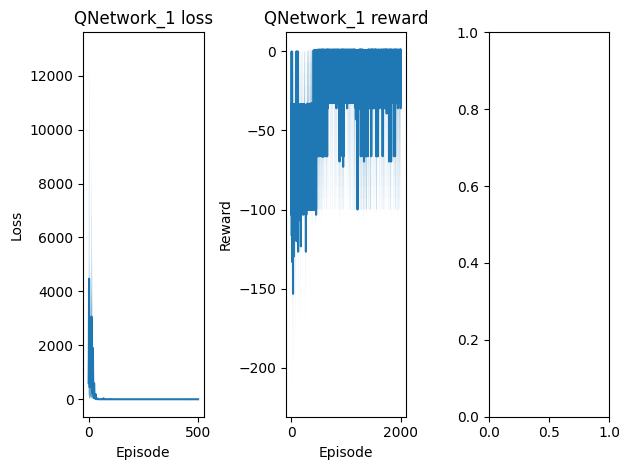

tensor(182.6347, device='cuda:0', grad_fn=<AddBackward0>)
-100.0


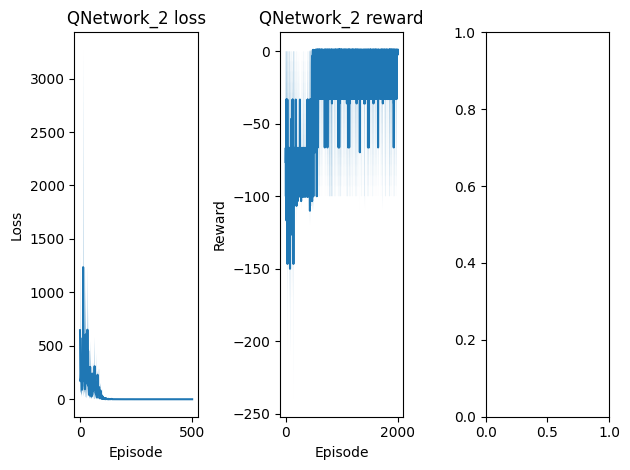

tensor(161.0663, device='cuda:0', grad_fn=<AddBackward0>)
-100.0


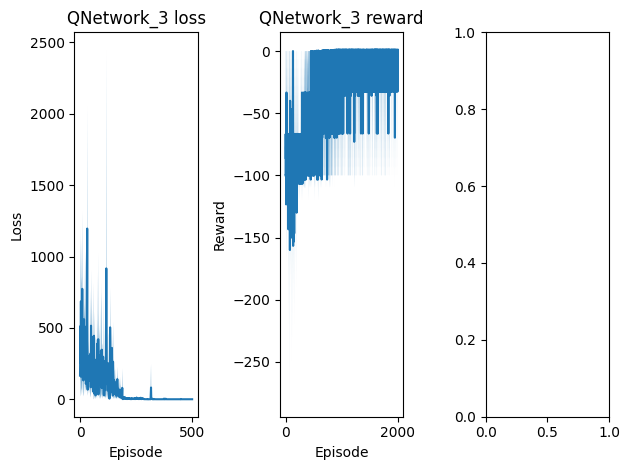

tensor(338.8924, device='cuda:0', grad_fn=<AddBackward0>)
-100.0


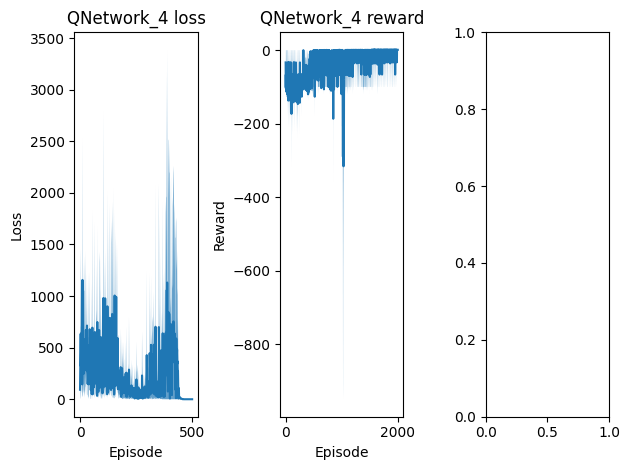

In [ ]:
for i, network in enumerate(networks):

    fig, ax = plt.subplots(ncols=3)

    losses = np.array([[0 if type(l) == int else l.cpu().detach().numpy() for l in loss] for loss in data[network]["loss"]])
    rewards = np.array([[l for l in reward] for reward in data[network]["train_reward"]])
    eval_rewards = np.array([[l for l in reward] for reward in data[network]["eval_reward"]])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.array(list(range(len(mean_loss))))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.array(list(range(len(mean_eval_reward))))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.array(list(range(len(mean_reward))))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{netwrok_names[i]} loss")
    ax[1].set_title(f"{netwrok_names[i]} eval reward")
    ax[2].set_title(f"{netwrok_names[i]} train reward")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")
    plt.tight_layout()
    plt.show()